# **Twitter Hate Speech Detection**

# Importing Libraries

In [3]:
# Import necessary libraries
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pickle
import time

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from lazypredict.Supervised import LazyClassifier, LazyRegressor

# Suppress warnings
import warnings 
warnings.filterwarnings('ignore')

## Dataset 1

In [4]:
# Reading the first training dataset
train1 = pd.read_csv("/data/ARENAS_Automatic_Extremist_Analysis/ARENAS_Automatic_Extremist_Analysis/Data/Hate_speech_data/train_E6oV3lV.csv")
print("Training Set 1 Columns and Shape:", train1.columns, train1.shape)

# Reading the first test dataset
test1 = pd.read_csv('/data/ARENAS_Automatic_Extremist_Analysis/ARENAS_Automatic_Extremist_Analysis/Data/Hate_speech_data/test_tweets_anuFYb8.csv')
print("Test Set 1 Columns and Shape:", test1.columns, test1.shape)

print('Train Set 1 -----')
print(train1.isnull().sum())
print('Test Set 1 -----')
print(test1.isnull().sum())
train1.head()



Training Set 1 Columns and Shape: Index(['id', 'label', 'tweet'], dtype='object') (31962, 3)
Test Set 1 Columns and Shape: Index(['id', 'tweet'], dtype='object') (17197, 2)
Train Set 1 -----
id       0
label    0
tweet    0
dtype: int64
Test Set 1 -----
id       0
tweet    0
dtype: int64


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


## Dataset 2

In [5]:
# Reading the second dataset
df = pd.read_csv('/data/ARENAS_Automatic_Extremist_Analysis/ARENAS_Automatic_Extremist_Analysis/Data/Hate_speech_data/toxicity_parsed_dataset.csv')
df.head()

# Selecting relevant columns from the second dataset
df = df[['index', 'oh_label', 'Text']]
df.head()

# Renaming columns for consistency
print("\nBefore modifying column names:\n", df.columns)
df.rename(columns={'index': 'id', 'oh_label': 'label', 'Text': 'tweet'}, inplace=True)
print("\nAfter modifying column names:\n", df.columns)

# Splitting the second dataset into training and testing subsets
train2, test2 = train_test_split(df, test_size=0.3, random_state=10, shuffle=True)

# Selecting relevant columns for the training and testing subsets
train2 = train2[['id', 'label', 'tweet']]
test2 = test2[['id', 'tweet']]

print("Training Set 2 Columns and Shape:", train2.columns, train2.shape)
print("Test Set 2 Columns and Shape:", test2.columns, test2.shape)
print('Train Set 2 -----')
print(train2.isnull().sum())
print('Test Set 2 -----')
print(test2.isnull().sum())
train2.head()


Before modifying column names:
 Index(['index', 'oh_label', 'Text'], dtype='object')

After modifying column names:
 Index(['id', 'label', 'tweet'], dtype='object')
Training Set 2 Columns and Shape: Index(['id', 'label', 'tweet'], dtype='object') (111780, 3)
Test Set 2 Columns and Shape: Index(['id', 'tweet'], dtype='object') (47906, 2)
Train Set 2 -----
id       0
label    0
tweet    0
dtype: int64
Test Set 2 -----
id       0
tweet    0
dtype: int64


,id,label,tweet
69140,69140,0,", 30 July 2008 (UTC) *: *double-checks your us..."
157499,157499,0,born 31march 1995 Yes
83922,83922,0,dated prod|concern = confirmed sockpuppet] of ...
30953,30953,0,Where is that documented? It's certainly not...
150734,150734,0,`:Perfectly fine - we'll appreciate your contr...


## Merging datasets

In [4]:
# Merging the two training datasets
train = pd.concat([train1, train2], ignore_index=True)
print("Combined Training Set Shape:", train.shape)
train['label'].value_counts()

# Merging the two test datasets
test = pd.concat([test1, test2], ignore_index=True)
print("Combined Test Set Shape:", test.shape)


Combined Training Set Shape: (143742, 3)
Combined Test Set Shape: (65103, 2)


## Data Analysis and Cleaning

In [5]:
# Define a function to clean text data
def clean_text(df, text_field):
    # Convert text to lowercase
    df[text_field] = df[text_field].str.lower()
    # Remove special characters, URLs, and other patterns
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
    return df

# Clean the text in the 'tweet' column of the test and train dataframes
test_clean = clean_text(test, "tweet")
train_clean = clean_text(train, "tweet")

# Separate the majority and minority classes in the training data
train_majority = train_clean[train_clean.label == 0]
train_minority = train_clean[train_clean.label == 1]

# Upsample the minority class to balance the dataset
train_minority_upsampled = resample(train_minority,
                                    replace=True,
                                    n_samples=len(train_majority),
                                    random_state=123)

# Combine the upsampled minority class with the majority class
train_upsampled = pd.concat([train_minority_upsampled, train_majority])

# Display the class distribution in the upsampled dataset
print(train_upsampled['label'].value_counts())

# Extract the label and tweet columns from the upsampled dataset
dt_transformed = train_upsampled[['label', 'tweet']]
y = dt_transformed.iloc[:, :-1].values

# Apply one-hot encoding to the 'label' column
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
y = np.array(ct.fit_transform(y))

# Convert the one-hot encoded labels into a DataFrame
y_df = pd.DataFrame(y)

# Extract the one-hot encoded label for the 'hate' class 
y_hate = np.array(y_df[0])

# Apply Count Vectorization to the 'tweet' column to create a feature matrix
cv = CountVectorizer(max_features=2000)
x = cv.fit_transform(train_upsampled['tweet']).toarray()

# Now 'y_hate' contains the labels and 'x' contains the corresponding text features


label
1    130760
0    130760
Name: count, dtype: int64


## Train & test splitting the data

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y_hate, test_size = 0.30, random_state = 1)

# **Testing With Different Models**
## Gaussian Naive Bayes, Decision Tree, K Nearest Neighbors, Random Forest, SVM

## Naive Bayes

In [7]:
# Create a Gaussian Naive Bayes classifier
classifier_np = GaussianNB()

# Start a timer to measure the training time
start_time = time.time()

# Train the Naive Bayes classifier using the training data
classifier_np.fit(x_train, y_train)

# Stop the timer and calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Print the training time
print(f"Training time of Naive Bayes: {training_time:.6f} seconds")

# Save the trained Naive Bayes classifier to a file
filename = 'twitter_with_two_dataset_model_GaussianNB.sav'
with open(filename, 'wb') as model_file:
    pickle.dump(classifier_np, model_file)


Training time of Naive Bayes: 6.624955 seconds


## Decision Tree

In [8]:
# Create a Decision Tree classifier with the specified criteria
classifier_dt = DecisionTreeClassifier(criterion='entropy', random_state=0)

# Start a timer to measure the training time
start_time = time.time()

# Train the Decision Tree classifier using the training data
classifier_dt.fit(x_train, y_train)

# Stop the timer and calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Print the training time
print(f"Training time of Decision Tree: {training_time:.6f} seconds")

# Save the trained Decision Tree classifier to a file
filename = 'twitter_with_two_dataset_model_Decision_Tree.sav'
with open(filename, 'wb') as model_file:
    pickle.dump(classifier_dt, model_file)

Training time of Decision Tree: 177.622541 seconds


## K-Nearest Neighbors

In [9]:
# Create a KNN classifier with the specified parameters
classifier_knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)

# Start a timer to measure the training time
start_time = time.time()

# Train the KNN classifier using the training data
classifier_knn.fit(x_train, y_train)

# Stop the timer and calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Print the training time
print(f"Training time of KNN: {training_time:.6f} seconds")

# Save the trained KNN classifier to a file
filename = 'twitter_with_two_dataset_model_KNN.sav'
with open(filename, 'wb') as model_file:
    pickle.dump(classifier_knn, model_file)

Training time of KNN: 0.011830 seconds


## Logistic Regression

In [10]:
# Create a Logistic Regression classifier with default parameters
classifier_lr = LogisticRegression(random_state=0)

# Start a timer to measure the training time
start_time = time.time()

# Train the Logistic Regression classifier using the training data
classifier_lr.fit(x_train, y_train)

# Stop the timer and calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Print the training time
print(f"Training time of Logistic Regression: {training_time:.6f} seconds")

# Save the trained Logistic Regression classifier to a file
filename = 'twitter_with_two_dataset_model_Logistic_Regression.sav'
with open(filename, 'wb') as model_file:
    pickle.dump(classifier_lr, model_file)

Training time of Logistic Regression: 40.494036 seconds


## Random Forest

In [11]:
# Create a Random Forest classifier with the specified parameters
classifier_rf = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)

# Start a timer to measure the training time
start_time = time.time()

# Train the Random Forest classifier using the training data
classifier_rf.fit(x_train, y_train)

# Stop the timer and calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Print the training time
print(f"Training time of Random Forest: {training_time:.6f} seconds")

# Save the trained Random Forest classifier to a file
filename = 'twitter_with_two_dataset_model_Random_Forest.sav'
with open(filename, 'wb') as model_file:
    pickle.dump(classifier_rf, model_file)

Training time of Random Forest: 51.582636 seconds


## SVM 

In [ ]:
"""# Create an instance of the SVM classifier with a linear kernel
classifier_svm = svm.SVC(kernel='linear')

# Start a timer to measure the training time
start_time = time.time()

# Train the SVM classifier using the training data
classifier_svm.fit(x_train, y_train)

# Stop the timer and calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Print the training time
print(f"Training time of SVM: {training_time:.6f} seconds")

# Save the trained SVM classifier to a file
filename = 'twitter_with_two_dataset_model_SVM.sav'
with open(filename, 'wb') as model_file:
    pickle.dump(classifier_svm, model_file)"""

In [ ]:
"""
# short version
# Define the fraction of data you want to keep (e.g., 10%)
fraction_to_keep = 0.1

# Determine the number of samples to keep
num_samples_to_keep = int(len(x_train) * fraction_to_keep)

# Randomly select a subset of data
indices = np.random.choice(len(x_train), num_samples_to_keep, replace=False)
x_train_subset = x_train[indices]
y_train_subset = y_train[indices]

# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the subset of training data
x_train_scaled = scaler.fit_transform(x_train_subset)

# Create an instance of the SVM classifier with a linear kernel
classifier_svm = svm.SVC(kernel='linear')

# Start a timer to measure the training time
start_time = time.time()

# Fit the SVM classifier on the scaled subset of data
classifier_svm.fit(x_train_scaled, y_train_subset)

# Stop the timer and calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Print the training time
print(f"Training time of SVM: {training_time:.6f} seconds")

# Save the trained SVM classifier to a file
filename = 'twitter_with_two_dataset_model_SVM.sav'
with open(filename, 'wb') as model_file:
    pickle.dump(classifier_svm, model_file)"""

# Confusion Matrix for Different Models

## Naive Bayes

Confusion Matrix for Naive Bayes:
[[18011 21485]
 [  675 38285]]


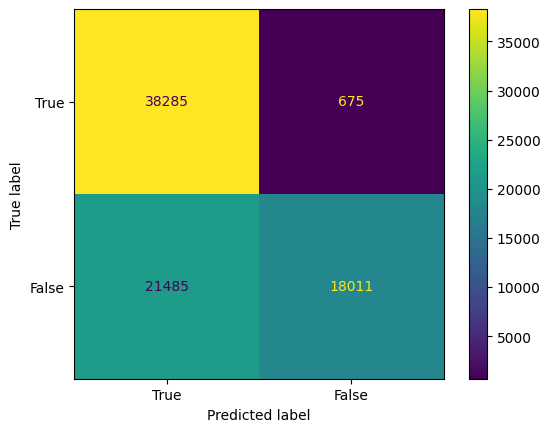

ROC-AUC for Naive Bayes: 0.7255


In [12]:
# Naive Bayes
# Make predictions using the Naive Bayes classifier
y_pred_np = classifier_np.predict(x_test)

# Calculate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred_np)
print("Confusion Matrix for Naive Bayes:")
print(cm)

# Display the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_np, labels=[1, 0]),
    display_labels=[True, False]
)
cm_display.plot()
plt.show()

# Calculate ROC-AUC for Naive Bayes
yhat_np = classifier_np.predict_proba(x_test)
yhat_np = yhat_np[:, 1]
fpr_np, tpr_np, _ = metrics.roc_curve(y_test, yhat_np)
auc_np = round(metrics.roc_auc_score(y_test, yhat_np), 4)
print(f'ROC-AUC for Naive Bayes: {auc_np}')


## Decision Tree

Confusion Matrix for Decision Tree:
[[39296   200]
 [ 2767 36193]]


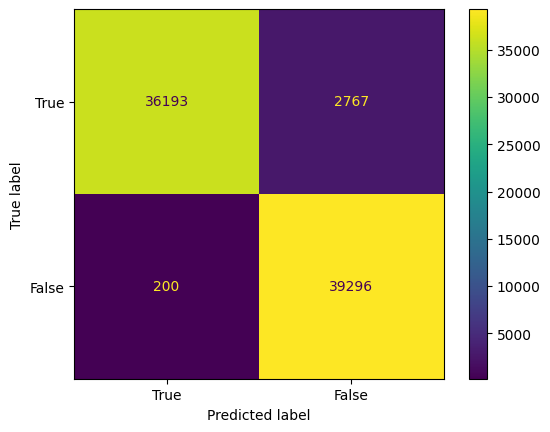

ROC-AUC for Decision Tree: 0.9688


In [14]:
# Decision Tree
# Make predictions using the Decision Tree classifier
y_pred_dt = classifier_dt.predict(x_test)

# Calculate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix for Decision Tree:")
print(cm)

# Display the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_dt, labels=[1, 0]),
    display_labels=[True, False]
)
cm_display.plot()
plt.show()

# Calculate ROC-AUC for Decision Tree
yhat_dt = classifier_dt.predict_proba(x_test)
yhat_dt = yhat_dt[:, 1]
fpr_dt, tpr_dt, _ = metrics.roc_curve(y_test, yhat_dt)
auc_dt = round(metrics.roc_auc_score(y_test, yhat_dt), 4)
print(f'ROC-AUC for Decision Tree: {auc_dt}')


## K-Nearest Neighbors

Confusion Matrix for KNN:
[[38910   586]
 [ 7470 31490]]


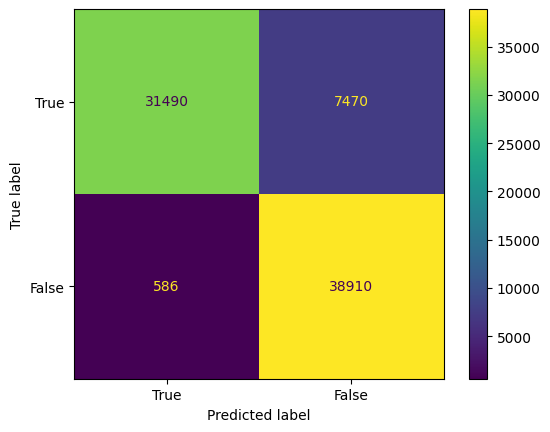

ROC-AUC for KNN: 0.9655


In [15]:
# K-Nearest Neighbors (KNN)
# Make predictions using the KNN classifier
y_pred_knn = classifier_knn.predict(x_test)

# Calculate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix for KNN:")
print(cm)

# Display the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_knn, labels=[1, 0]),
    display_labels=[True, False]
)
cm_display.plot()
plt.show()

# Calculate ROC-AUC for KNN
yhat_knn = classifier_knn.predict_proba(x_test)
yhat_knn = yhat_knn[:, 1]
fpr_knn, tpr_knn, _ = metrics.roc_curve(y_test, yhat_knn)
auc_knn = round(metrics.roc_auc_score(y_test, yhat_knn), 4)
print(f'ROC-AUC for KNN: {auc_knn}')


## Logistic Regression

Confusion Matrix for Logistic Regression:
[[33402  6094]
 [ 3524 35436]]


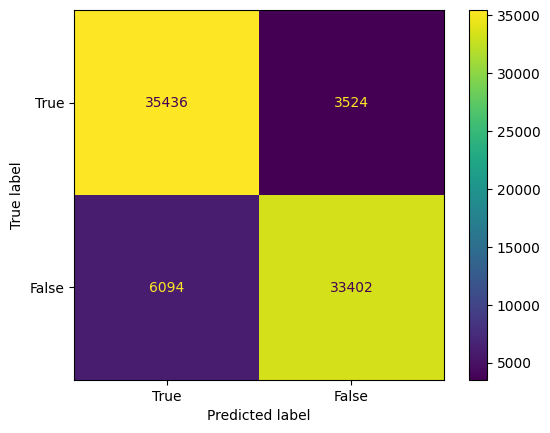

ROC-AUC for Logistic Regression: 0.9508


In [16]:
# Logistic Regression
# Make predictions using the Logistic Regression classifier
y_pred_lr = classifier_lr.predict(x_test)

# Calculate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix for Logistic Regression:")
print(cm)

# Display the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_lr, labels=[1, 0]),
    display_labels=[True, False]
)
cm_display.plot()
plt.show()

# Calculate ROC-AUC for Logistic Regression
yhat_lr = classifier_lr.predict_proba(x_test)
yhat_lr = yhat_lr[:, 1]
fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test, yhat_lr)
auc_lr = round(metrics.roc_auc_score(y_test, yhat_lr), 4)
print(f'ROC-AUC for Logistic Regression: {auc_lr}')


## Random Forest

Confusion Matrix for Random Forest:
[[39306   190]
 [ 1246 37714]]


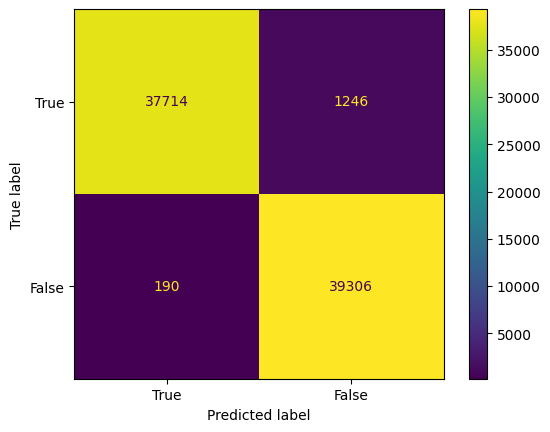

ROC-AUC for Random Forest: 0.9987


In [17]:
# Random Forest
# Make predictions using the Random Forest classifier
y_pred_rf = classifier_rf.predict(x_test)

# Calculate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix for Random Forest:")
print(cm)

# Display the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_rf, labels=[1, 0]),
    display_labels=[True, False]
)
cm_display.plot()
plt.show()

# Calculate ROC-AUC for Random Forest
yhat_rf = classifier_rf.predict_proba(x_test)
yhat_rf = yhat_rf[:, 1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, yhat_rf)
auc_rf = round(metrics.roc_auc_score(y_test, yhat_rf), 4)
print(f'ROC-AUC for Random Forest: {auc_rf}')


## Support Vector Machine

[[33272  6224]
 [ 5617 33343]]


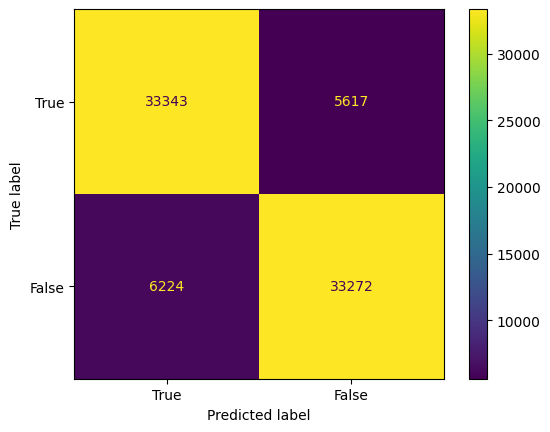

In [20]:
"""
# Optionally, transform your test data using the same scaler
x_test_scaled = scaler.transform(x_test)

# Make predictions on the scaled test data
y_pred_svm = classifier_svm.predict(x_test_scaled)

# Calculate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix for SVM:")
print(cm)

# Display the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_svm, labels=[1, 0]),
    display_labels=[True, False]
)
cm_display.plot()
plt.show()

# Calculate ROC-AUC for SVM
yhat_svm = classifier_svm.decision_function(x_test_scaled)
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_test, yhat_svm)
auc_svm = round(metrics.roc_auc_score(y_test, yhat_svm), 4)
print(f'ROC-AUC for SVM: {auc_svm}')"""


# Generating the Accuracy & F1 Score

In [18]:
rf_score = accuracy_score(y_test, y_pred_rf)
knn_score = accuracy_score(y_test, y_pred_knn)
lr_score = accuracy_score(y_test, y_pred_lr)
dt_score = accuracy_score(y_test, y_pred_dt)
np_score = accuracy_score(y_test, y_pred_np)

print ('--' * 20)
print('Random Forest Accuracy: ', str(rf_score))
print('F1 score: ', f1_score(y_test, y_pred_rf, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('K-Nearest Neighbors Accuracy: ', str(knn_score))
print('F1 score: ', f1_score(y_test, y_pred_knn, labels = [1,0]))
print ('--' * 20)
print ('')

print ('--' * 20)
print('Logistic Regression Accuracy: ',str(lr_score))
print('F1 score: ', f1_score(y_test, y_pred_lr, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Decision Tree Accuracy: ', str(dt_score))
print('F1 score: ', f1_score(y_test, y_pred_dt, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Naive Bayes Accuracy: ', str(np_score))
print('F1 score: ', f1_score(y_test, y_pred_np, labels = [1,0]))
print ('--' * 20)
print ('')

----------------------------------------
Random Forest Accuracy:  0.9816967472213725
F1 score:  0.9813176519567026
----------------------------------------

----------------------------------------
K-Nearest Neighbors Accuracy:  0.8973182420719894
F1 score:  0.8865927135536911
----------------------------------------

----------------------------------------
Logistic Regression Accuracy:  0.8774089935760171
F1 score:  0.8805068952664927
----------------------------------------

----------------------------------------
Decision Tree Accuracy:  0.962182624655858
F1 score:  0.9606253234774992
----------------------------------------

----------------------------------------
Naive Bayes Accuracy:  0.7175486897114306
F1 score:  0.7755494783753671
----------------------------------------



In [22]:
"""svm_score = accuracy_score(y_test, y_pred_svm)
print ('--' * 20)
print('Support Vector Machine Accuracy: ', str(svm_score))
print('F1 score: ', f1_score(y_test, y_pred_svm, labels = [1,0]))
print ('--' * 20)
print ('')"""

----------------------------------------
Support Vector Machine Accuracy:  0.8490746405628633
F1 score:  0.8492110993670967
----------------------------------------

